In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

C:\Users\Siby\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


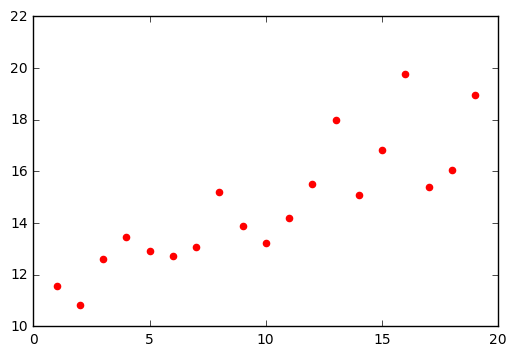

In [2]:
df1=pd.read_csv("x_y_data.csv")   #Importing data
col1 = df1['X']
col2 = df1['Y']
x1 = col1.as_matrix()
y1_ = col2.as_matrix()
plt.scatter(x1,y1_,color='red')   #Plotting data

In [3]:
#PSO parameters
c1 = 0.1  #PSO hyperparametre
c2 =0.1
P = 30   #Number of particles
N = 500 #Number of Iterations

In [4]:
def swarm(P=10):  #Define partilces
    Wpc = tf.Variable(tf.random_normal([P])) #Current value
    bpc = tf.Variable(tf.random_normal([P]))
    fitness_pc = tf.Variable(tf.zeros([P]))
    
    Wpbest= tf.Variable(tf.random_normal([P]))
    bpbest= tf.Variable(tf.random_normal([P]))
    fitness_pbest = tf.Variable(tf.zeros([P]))
    
    Wglobal= tf.Variable(tf.random_normal([1]))
    bglobal= tf.Variable(tf.random_normal([1]))
    fitness_global = tf.Variable(tf.zeros([1]))
    
    V_W = tf.Variable(tf.zeros([P]))   #Particle velocity
    V_b = tf.Variable(tf.zeros([P]))
    return Wpc,bpc,Wpbest,bpbest,Wglobal,bglobal,V_W,V_b,fitness_pc,fitness_pbest,fitness_global

Wpc,bpc,Wpbest,bpbest,Wglobal,bglobal,V_W,V_b,fitness_pc,fitness_pbest,fitness_global =swarm(P)
print(Wglobal)

Tensor("Variable_6/read:0", shape=(1,), dtype=float32)


In [5]:

x = tf.placeholder(tf.float32)
W = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
i = tf.placeholder(tf.int32)
y_ = tf.placeholder(tf.float32)

In [6]:
#Update particles
V_W_update = V_W[i].assign(V_W[i]+(Wpbest[i] - Wpc[i])*c1*np.random.random() +(Wglobal[0] - Wpc[i])*c2*np.random.random() )
V_b_update = V_b[i].assign(V_b[i]+(bpbest[i] - bpc[i])*c1*np.random.random() +(bglobal[0] - bpc[i])*c2*np.random.random() )
Wp_update = Wpc[i].assign(V_W[i]+Wpc[i])
bp_update = bpc[i].assign(V_b[i]+bpc[i])

#Cost
y = Wpc[i]*x + bpc[i]
y_best = Wglobal[0]*x + bglobal[0]
error= tf.reduce_mean(tf.square(y- y_))
#Update fitness
update_fitness_pc = fitness_pc[i].assign(error)
update_fitness_pbest = fitness_pbest[i].assign(fitness_pc[i])
update_fitness_global = fitness_global[0].assign(fitness_pc[i])
initialize_fitness_global = fitness_global[0].assign(tf.reduce_min(fitness_pbest))

update_Wpbest = Wpbest[i].assign(Wpc[i])
update_bpbest = bpbest[i].assign(bpc[i])
update_Wglobal = Wglobal[0].assign(Wpc[i])
update_bglobal = bglobal[0].assign(bpc[i])

def f1():return [Wpbest[i].assign(Wpc[i]),bpbest[i].assign(bpc[i]),fitness_pbest[i].assign(fitness_pc[i])]
def f2():return [Wpbest[i],bpbest[i],fitness_pbest[i]]
pbest_update= tf.cond(tf.less(fitness_pc[i], fitness_pbest[i]), f1, f2)

def f3():return [Wglobal[0].assign(Wpc[i]),bglobal[0].assign(bpc[i]),fitness_global[0].assign(fitness_pc[i])]
def f4():return [Wglobal[0],bglobal[0],fitness_global[0]]
global_update= tf.cond(tf.less(fitness_pc[i], fitness_global[0]), f3, f4)


In [7]:
start_time = time.time()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    sess.run([V_W_update,V_b_update],feed_dict={i:0})
    sess.run([Wp_update,bp_update],feed_dict={i:0})
   
    for k in range(P):     #Initialize particles
        sess.run([update_fitness_pc],feed_dict={i:k,x:x1,y_:y1_})
        sess.run([update_fitness_pbest],feed_dict={i:k})
    sess.run([initialize_fitness_global])
    print("Particle fitness:",sess.run(fitness_pc))
    print("Global fitness:",sess.run(fitness_global))
    
    for j in range(N):      #Loop over N iterations
        for k in range(P):  #Loop over P particles
            
            sess.run([V_W_update,V_b_update],feed_dict={i:k})
            sess.run([Wp_update,bp_update],feed_dict={i:k})
            sess.run([update_fitness_pc],feed_dict={i:k,x:x1,y_:y1_})
            
           
            sess.run([pbest_update],feed_dict={i:k}) 
           
            sess.run([global_update],feed_dict={i:k})
                        
            
        if j%50== 0:
            print("Iteration:",j)    
    print("Particle best fitness:",sess.run(fitness_pbest)) 
    print("Global best fitness:",sess.run(fitness_global)) 
    print("Global best particle:",sess.run([Wglobal,bglobal]))  
    
    yfinal =sess.run([y_best],feed_dict={x:x1,y_:y1_}) #storing values
print("Time taken:", (time.time() - start_time))        

Particle fitness: [  119.44880676   325.26739502    63.47898865   138.46643066   126.3000946
   130.27157593   488.79714966   187.39117432    30.29364586    40.56044388
    29.67288589    63.12273407   271.03540039   550.14672852    41.08478165
   103.86564636    48.12801361   159.07382202    32.86349487   785.2791748
    82.94963074   793.23181152   174.69995117   313.41827393    64.50994873
  1303.04797363    45.47896194    34.18169403   229.8939209    383.10617065]
Global fitness: [ 29.67288589]
Iteration: 0
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Iteration: 300
Iteration: 350
Iteration: 400
Iteration: 450
Particle best fitness: [ 1.55862439  1.51461995  1.49847364  1.51188374  1.49782944  1.55737257
  1.49745011  1.49908888  1.50746918  1.51665199  1.49794161  1.50588655
  1.49734902  1.49783599  1.49792409  1.49818957  1.50252676  1.51077902
  1.49849248  1.49620497  1.56630623  1.53947163  1.49599135  1.49559176
  1.58056188  1.50206459  1.509830

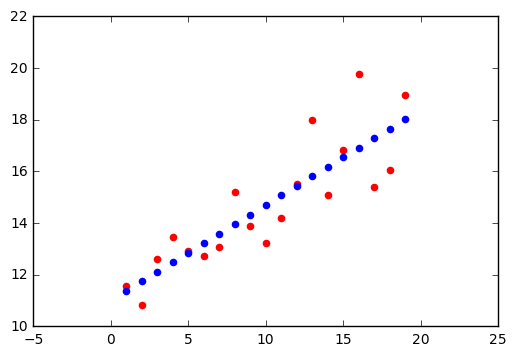

In [8]:
plt.scatter(x1,y1_,color='red')  #Plot original line
plt.scatter(x1,yfinal,color='blue')   #Plot fitted line